In [21]:
import os

def extract_class_zero_labels(input_folder, output_folder):
    """
    Reads YOLO .txt label files from input_folder,
    filters out only class 1 labels (which represent the empty shelves),
    replaces the class 1 with 0, 
    and writes them to output_folder.
    """
    os.makedirs(output_folder, exist_ok=True)

    for filename in os.listdir(input_folder):
        if filename.endswith(".txt"):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)

            with open(input_path, 'r') as infile:
                lines = infile.readlines()

            # Filter lines that start with '1 ' (class 1 labels)
            filtered_lines = []
            for line in lines:
                if line.strip().startswith("1 "):
                    # Replace the class 1 with class 0
                    updated_line = line.replace("1 ", "0 ", 1)
                    filtered_lines.append(updated_line)

            if filtered_lines:
                with open(output_path, 'w') as outfile:
                    outfile.writelines(filtered_lines)

    print(f"Done! Filtered labels saved to: {output_folder}")

input_folder = "oos/test/labels"
output_folder = "oos/test/test_labels_class0"

extract_class_zero_labels(input_folder, output_folder)


Done! Filtered labels saved to: oos/test/test_labels_class0


Processing: train_6966_jpg.rf.96eb99afa9a1e6543cb5f2af894900b2
Processing: train_2853_jpg.rf.e35166f6f5f77e4b4503a4077e98529e
Processing: train_6144_jpg.rf.9fc74580cac57127a48304de79287d20
Processing: train_4330_jpg.rf.024b37c4d3bdf8ff190e290ef825ecc6
Processing: train_7640_jpg.rf.bccb81a1d968befebb39dcf405ef058f
Processing: train_6431_jpg.rf.b9a533efc5bc2c44ef4ea31b68744584
Processing: test_1698_jpg.rf.7d315a0cd95cbf7049552fe2428934d3
Processing: test_2080_jpg.rf.8a304764d75908aff46b121fcba2754b
Processing: test_2667_jpg.rf.f7f5e947e55ad65547e423aba2800692
Processing: train_3921_jpg.rf.2eb0c67f03d0dac3c68ec4efbb8454b4
Processing: test_581_jpg.rf.fd832af73ccd1604ce13c0dc12486bc4
Processing: train_5413_jpg.rf.96bf347120fefd617e35cd358ac43ee5
Processing: train_6364_jpg.rf.dad8229d0ec8f5d5c8bc02febac67336
Processing: train_8022_jpg.rf.ab77c26567b065ad00cb81ddbc20c0c5
Processing: test_609_jpg.rf.d04192709a5f14389f216c2aac1f25f2
Processing: train_7514_jpg.rf.31dcf24d5df6e99e6cc4775a4d01e394

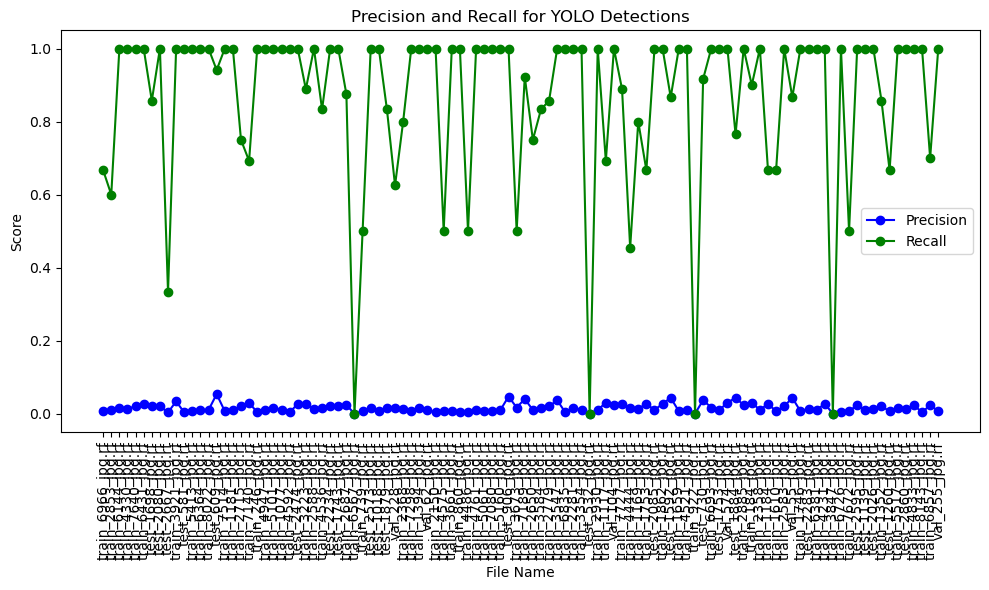

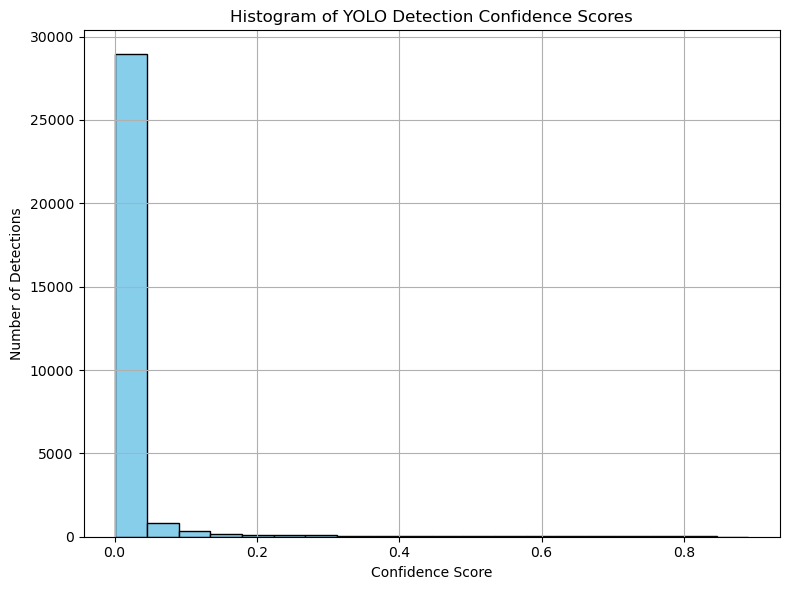

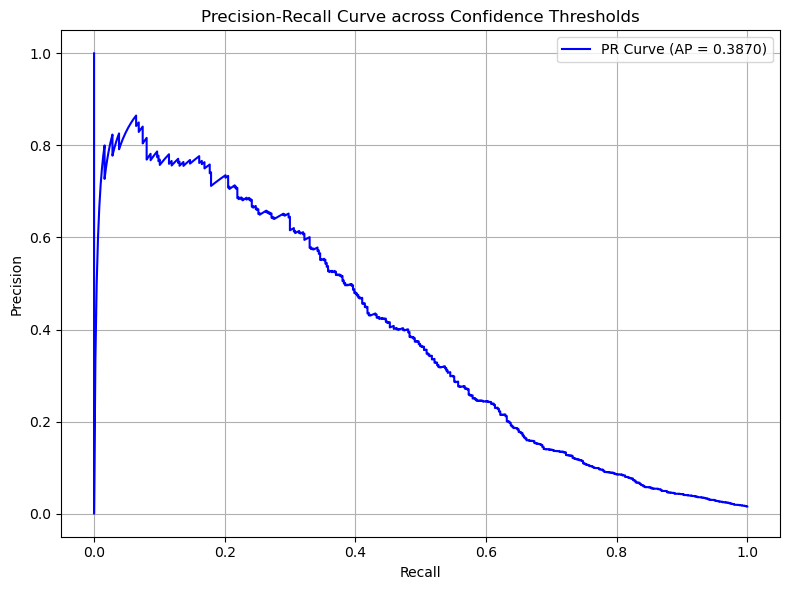

In [23]:
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Function to calculate IoU (Intersection over Union)
def iou(box1, box2):
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2

    # intersection coordinates
    inter_x_min = max(x1_min, x2_min)
    inter_y_min = max(y1_min, y2_min)
    inter_x_max = min(x1_max, x2_max)
    inter_y_max = min(y1_max, y2_max)

    inter_area = max(0, inter_x_max - inter_x_min) * max(0, inter_y_max - inter_y_min)

    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)

    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area if union_area != 0 else 0

def convert_to_bbox_coordinates(x_center, y_center, width, height):
    xmin = x_center - width / 2
    ymin = y_center - height / 2
    xmax = x_center + width / 2
    ymax = y_center + height / 2
    return [xmin, ymin, xmax, ymax]

def load_ground_truth(gt_path):
    with open(gt_path, 'r') as f:
        gt_boxes = []
        for line in f.readlines():
            parts = list(map(float, line.split()))
            class_id = int(parts[0])
            x_center = parts[1]
            y_center = parts[2]
            width = parts[3]
            height = parts[4]
            bbox = convert_to_bbox_coordinates(x_center, y_center, width, height)
            gt_boxes.append((class_id, bbox))
    return gt_boxes

def load_yolo_detections(yolo_path):
    with open(yolo_path, 'r') as f:
        detections = []
        for line in f.readlines():
            parts = list(map(float, line.split()))
            class_id = int(parts[0])
            x_center = parts[1]
            y_center = parts[2]
            width = parts[3]
            height = parts[4]
            confidence = parts[5]
            bbox = convert_to_bbox_coordinates(x_center, y_center, width, height)
            detections.append((class_id, bbox, confidence))
    return detections

def evaluate_precision_recall(gt_boxes, yolo_detections, iou_threshold=0.5):
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    matched_gt = set()

    for yolo_class_id, yolo_bbox, confidence in yolo_detections:
        best_iou = 0
        best_match_gt = None

        for i, (gt_class_id, gt_bbox) in enumerate(gt_boxes):
            if gt_class_id == yolo_class_id and i not in matched_gt:
                current_iou = iou(gt_bbox, yolo_bbox)
                if current_iou > best_iou:
                    best_iou = current_iou
                    best_match_gt = i
        
        if best_iou >= iou_threshold:
            true_positives += 1
            matched_gt.add(best_match_gt)
        else:
            false_positives += 1

    false_negatives = len(gt_boxes) - len(matched_gt)

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

    return precision, recall

def process_detection_files(gt_folder, yolo_folder, iou_threshold=0.5):
    gt_files = glob.glob(os.path.join(gt_folder, "*.txt"))
    yolo_files = glob.glob(os.path.join(yolo_folder, "*.txt"))

    results = []
    filenames = []
    precision_list = []
    recall_list = []

    for gt_file in gt_files:
        file_name = os.path.basename(gt_file).replace('.txt', '')
        
        yolo_file = os.path.join(yolo_folder, file_name + '.txt')

        if os.path.exists(yolo_file):
            print(f"Processing: {file_name}")

            gt_boxes = load_ground_truth(gt_file)
            yolo_detections = load_yolo_detections(yolo_file)

            precision, recall = evaluate_precision_recall(gt_boxes, yolo_detections, iou_threshold)

            filenames.append(file_name)
            precision_list.append(precision)
            recall_list.append(recall)

            results.append((file_name, precision, recall))

    return results, filenames, precision_list, recall_list

def plot_precision_recall(filenames, precision, recall):
    fig, ax = plt.subplots(figsize=(10, 6))

    short_names = [os.path.splitext(os.path.basename(f))[0] for f in filenames]

    ax.plot(short_names, precision, label='Precision', marker='o', linestyle='-', color='b')
    ax.plot(short_names, recall, label='Recall', marker='o', linestyle='-', color='g')

    ax.set_xlabel('File Name')
    ax.set_ylabel('Score')
    ax.set_title('Precision and Recall for YOLO Detections')
    ax.legend()
    ax.set_xticks(range(len(short_names)))
    ax.set_xticklabels(short_names, rotation=90)

    plt.tight_layout()
    plt.show()



def gather_detections_and_labels(gt_folder, yolo_folder, iou_threshold=0.5):
    gt_files = glob.glob(os.path.join(gt_folder, "*.txt"))
    y_true = []
    y_scores = []

    for gt_file in gt_files:
        file_name = os.path.basename(gt_file).replace('.txt', '')
        yolo_file = os.path.join(yolo_folder, file_name + '.txt')
        if not os.path.exists(yolo_file):
            continue

        gt_boxes = load_ground_truth(gt_file)
        yolo_detections = load_yolo_detections(yolo_file)

        matched_gt = set()

        for det_class, det_box, confidence in yolo_detections:
            is_tp = False
            best_iou = 0
            best_match = -1

            for i, (gt_class, gt_box) in enumerate(gt_boxes):
                if gt_class == det_class and i not in matched_gt:
                    iou_score = iou(gt_box, det_box)
                    if iou_score > best_iou:
                        best_iou = iou_score
                        best_match = i

            if best_iou >= iou_threshold:
                is_tp = True
                matched_gt.add(best_match)

            y_true.append(1 if is_tp else 0)
            y_scores.append(confidence)

    return y_true, y_scores

def plot_precision_recall_curve(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    ap = average_precision_score(y_true, y_scores)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'PR Curve (AP = {ap:.4f})', color='blue')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve across Confidence Thresholds')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_confidence_histogram(y_scores):
    plt.figure(figsize=(8, 6))
    plt.hist(y_scores, bins=20, color='skyblue', edgecolor='black')
    plt.title('Histogram of YOLO Detection Confidence Scores')
    plt.xlabel('Confidence Score')
    plt.ylabel('Number of Detections')
    plt.grid(True)
    plt.tight_layout()
    plt.show()



def main():
    gt_folder = "oos/test/test_labels_class0" 
    yolo_folder = "runs/val/exp4/labels"

    results, filenames, precision, recall = process_detection_files(gt_folder, yolo_folder)

    for result in results:
        file_name, precision_val, recall_val = result
        print(f"File: {file_name}, Precision: {precision_val:.4f}, Recall: {recall_val:.4f}")

    plot_precision_recall(filenames, precision, recall)

    y_true, y_scores = gather_detections_and_labels(gt_folder, yolo_folder)

    plot_confidence_histogram(y_scores)

    plot_precision_recall_curve(y_true, y_scores)

if __name__ == "__main__":
    main()


 ## Blob Detection

In [24]:
def load_yolo_labels(label_path, img_shape):
    h, w = img_shape[:2]
    boxes = []
    with open(label_path) as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 5:
                continue
            cls, cx, cy, bw, bh = map(float, parts[:5])
            x1 = int((cx - bw / 2) * w)
            y1 = int((cy - bh / 2) * h)
            x2 = int((cx + bw / 2) * w)
            y2 = int((cy + bh / 2) * h)
            boxes.append((x1, y1, x2, y2))
    return boxes

image_path = "runs/detect/exp14/test_906_jpg.rf.543c0291439ba214189262216710fd54.jpg"
label_path = "runs/detect/exp14/labels/test_906_jpg.rf.543c0291439ba214189262216710fd54.txt"

In [25]:
import cv2
import numpy as np



def point_in_box(x, y, box):
    x1, y1, x2, y2 = box
    return x1 <= x <= x2 and y1 <= y <= y2


img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


params = cv2.SimpleBlobDetector_Params()
params.filterByArea = True
params.minArea = 100
params.maxArea = 3000
params.filterByCircularity = False
params.filterByConvexity = False
params.filterByInertia = False
params.minThreshold = 10
params.maxThreshold = 200
params.thresholdStep = 10

detector = cv2.SimpleBlobDetector_create(params)
keypoints = detector.detect(gray)


blob_img = cv2.drawKeypoints(img, keypoints, np.array([]), (0, 255, 255),
                             cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

boxes = load_yolo_labels(label_path, img.shape)

confirmed = 0
suspect = 0
matched_blobs = set()

for i, box in enumerate(boxes):
    x1, y1, x2, y2 = box
    matched = False
    for j, kp in enumerate(keypoints):
        x, y = kp.pt
        if point_in_box(x, y, box):
            matched = True
            matched_blobs.add(j)
            break
    if matched:
        confirmed += 1
        cv2.rectangle(blob_img, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green = confirmed
    else:
        suspect += 1
        cv2.rectangle(blob_img, (x1, y1), (x2, y2), (0, 0, 255), 2)  # Red = no blob match

# Blobs not matched by any YOLO box = missed
missed = len(keypoints) - len(matched_blobs)

cv2.imwrite("cross-val_yolo_vs_blobs.jpg", blob_img)

print("\n YOLO vs Blob Detection ")
print(f"Total YOLO Boxes:        {len(boxes)}")
print(f"Confirmed by Blob Match: {confirmed}")
print(f"Not Confirmed (Suspect): {suspect}")
print(f"Blobs Not Matched (Miss): {missed}")
print(f"Confirmation Rate:        {100 * confirmed / len(boxes):.2f}%")



 YOLO vs Blob Detection 
Total YOLO Boxes:        8
Confirmed by Blob Match: 7
Not Confirmed (Suspect): 1
Blobs Not Matched (Miss): 128
Confirmation Rate:        87.50%


## Edge Density Map

In [12]:
import cv2
import numpy as np
from skimage.filters import sobel


img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
edges = sobel(gray)

boxes = load_yolo_labels(label_path, img.shape)

# Threshold for texture
texture_threshold = 0.08
low_texture_count = 0
high_texture_count = 0

for x1, y1, x2, y2 in boxes:
    crop = edges[y1:y2, x1:x2]
    density = np.mean(crop)

    if density < texture_threshold:
        low_texture_count += 1
        color = (0, 255, 0)  # Green: likely truly empty
    else:
        high_texture_count += 1
        color = (0, 0, 255)  # Red: suspect empty
    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
    cv2.putText(img, f"{density:.2f}", (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

cv2.imwrite("cross-val_edge_density_check.jpg", img)

print("\n YOLO Edge Density Validation ")
print(f"Total YOLO Boxes:        {len(boxes)}")
print(f"Low-Texture (Confirmed): {low_texture_count}")
print(f"High-Texture (Suspect):  {high_texture_count}")
print(f"Confirmation Rate:       {100 * low_texture_count / len(boxes):.2f}%")



 YOLO Edge Density Validation 
Total YOLO Boxes:        8
Low-Texture (Confirmed): 7
High-Texture (Suspect):  1
Confirmation Rate:       87.50%


## Texture Cluster

In [13]:
import cv2
import numpy as np
from sklearn.cluster import KMeans

img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
flat = gray.reshape(-1, 1)

kmeans = KMeans(n_clusters=2, random_state=42).fit(flat)
clustered = kmeans.labels_.reshape(gray.shape)
cluster_img = (clustered * 127).astype(np.uint8)
output = cv2.cvtColor(cluster_img, cv2.COLOR_GRAY2BGR)

boxes = load_yolo_labels(label_path, img.shape)

low_cluster = 0 if np.mean(gray[clustered == 0]) < np.mean(gray[clustered == 1]) else 1
confirmed = 0
suspect = 0

for x1, y1, x2, y2 in boxes:
    crop_cluster = clustered[y1:y2, x1:x2]
    if crop_cluster.size == 0:
        continue
    majority_cluster = np.round(np.mean(crop_cluster))
    if majority_cluster == low_cluster:
        confirmed += 1
        color = (0, 255, 0)  # Green: confirms empty
    else:
        suspect += 1
        color = (0, 0, 255)  # Red: suspicious
    cv2.rectangle(output, (x1, y1), (x2, y2), color, 2)

cv2.imwrite("cross-val_texture_cluster_vs_yolo.jpg", output)

total = confirmed + suspect
print("\n YOLO Texture Cluster Confirmation ")
print(f"Total YOLO Boxes:            {total}")
print(f"Cluster-Confirmed (Low Tex): {confirmed}")
print(f"Cluster-Suspect (High Tex):  {suspect}")
print(f"Confirmation Rate:           {100 * confirmed / total:.2f}%")



 YOLO Texture Cluster Confirmation 
Total YOLO Boxes:            8
Cluster-Confirmed (Low Tex): 8
Cluster-Suspect (High Tex):  0
Confirmation Rate:           100.00%


## Yolo Contour

In [14]:
import cv2


def load_yolo_labels(label_path, img_shape):
    h, w = img_shape[:2]
    boxes = []
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 5:
                continue
            cls, cx, cy, bw, bh = map(float, parts[:5])
            x1 = int((cx - bw / 2) * w)
            y1 = int((cy - bh / 2) * h)
            x2 = int((cx + bw / 2) * w)
            y2 = int((cy + bh / 2) * h)
            boxes.append((x1, y1, x2, y2))
    return boxes

def compute_iou(boxA, boxB):
    xa1, ya1, xa2, ya2 = boxA
    xb1, yb1, xb2, yb2 = boxB
    inter_x1 = max(xa1, xb1)
    inter_y1 = max(ya1, yb1)
    inter_x2 = min(xa2, xb2)
    inter_y2 = min(ya2, yb2)
    inter_area = max(0, inter_x2 - inter_x1 + 1) * max(0, inter_y2 - inter_y1 + 1)
    boxA_area = (xa2 - xa1 + 1) * (ya2 - ya1 + 1)
    boxB_area = (xb2 - xb1 + 1) * (yb2 - yb1 + 1)
    iou = inter_area / float(boxA_area + boxB_area - inter_area)
    return iou

img = cv2.imread(image_path)
yolo_boxes = load_yolo_labels(label_path, img.shape)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 180, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

cv_boxes = []
for c in contours:
    if cv2.contourArea(c) > 500:
        x, y, w, h = cv2.boundingRect(c)
        cv_boxes.append((x, y, x + w, y + h))

TP, FP, FN = 0, 0, 0
iou_thresh = 0.3
matched_cv = set()
output = img.copy()

for y_box in yolo_boxes:
    matched = False
    for i, c_box in enumerate(cv_boxes):
        iou = compute_iou(y_box, c_box)
        if iou > iou_thresh:
            matched = True
            matched_cv.add(i)
            break
    if matched:
        FP += 1
        cv2.rectangle(output, (y_box[0], y_box[1]), (y_box[2], y_box[3]), (0, 0, 255), 2)  # Red = FP
    else:
        TP += 1
        cv2.rectangle(output, (y_box[0], y_box[1]), (y_box[2], y_box[3]), (0, 255, 0), 2)  # Green = TP

for i, c_box in enumerate(cv_boxes):
    if i not in matched_cv:
        FN += 1
        cv2.rectangle(output, (c_box[0], c_box[1]), (c_box[2], c_box[3]), (200, 100, 0), 2)  # Blue = FN

total_yolo = TP + FP
contour_match_rate = (TP / total_yolo * 100) if total_yolo > 0 else 0
missed_by_yolo = FN

print("\n YOLO vs Contour-Based Detection ")
print(f"Total YOLO Boxes:            {total_yolo}")
print(f"YOLO Confirmed by Contours:  {TP}")
print(f"YOLO Unconfirmed (No Match): {FP}")
print(f"Contour-Only Gaps (Missed):  {FN}")
print(f"YOLO Confirmation Rate:      {contour_match_rate:.2f}%")

cv2.imwrite("cross-val_yolo_vs_contour_result.jpg", output)



 YOLO vs Contour-Based Detection 
Total YOLO Boxes:            8
YOLO Confirmed by Contours:  8
YOLO Unconfirmed (No Match): 0
Contour-Only Gaps (Missed):  8
YOLO Confirmation Rate:      100.00%


True

## False Positives

In [16]:
image_path = "runs/detect/exp14/test_1036_jpg.rf.0475c92607c3d6b9e4179b44652b24cb.jpg"
label_path = "runs/val/exp4/labels/test_1036_jpg.rf.0475c92607c3d6b9e4179b44652b24cb.txt"

In [17]:
import cv2
import numpy as np



def point_in_box(x, y, box):
    x1, y1, x2, y2 = box
    return x1 <= x <= x2 and y1 <= y <= y2


img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


params = cv2.SimpleBlobDetector_Params()
params.filterByArea = True
params.minArea = 100
params.maxArea = 3000
params.filterByCircularity = False
params.filterByConvexity = False
params.filterByInertia = False
params.minThreshold = 10
params.maxThreshold = 200
params.thresholdStep = 10

detector = cv2.SimpleBlobDetector_create(params)
keypoints = detector.detect(gray)


blob_img = cv2.drawKeypoints(img, keypoints, np.array([]), (0, 255, 255),
                             cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

boxes = load_yolo_labels(label_path, img.shape)

confirmed = 0
suspect = 0
matched_blobs = set()

for i, box in enumerate(boxes):
    x1, y1, x2, y2 = box
    matched = False
    for j, kp in enumerate(keypoints):
        x, y = kp.pt
        if point_in_box(x, y, box):
            matched = True
            matched_blobs.add(j)
            break
    if matched:
        confirmed += 1
        cv2.rectangle(blob_img, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green = confirmed
    else:
        suspect += 1
        cv2.rectangle(blob_img, (x1, y1), (x2, y2), (0, 0, 255), 2)  # Red = no blob match

missed = len(keypoints) - len(matched_blobs)

cv2.imwrite("misclassification_yolo_vs_blobs.jpg", blob_img)

print("\n YOLO vs Blob Detection ")
print(f"Total YOLO Boxes:        {len(boxes)}")
print(f"Confirmed by Blob Match: {confirmed}")
print(f"Not Confirmed (Suspect): {suspect}")
print(f"Blobs Not Matched (Miss): {missed}")
print(f"Confirmation Rate:        {100 * confirmed / len(boxes):.2f}%")


img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
edges = sobel(gray)

boxes = load_yolo_labels(label_path, img.shape)

# Threshold for texture
texture_threshold = 0.08
low_texture_count = 0
high_texture_count = 0

for x1, y1, x2, y2 in boxes:
    crop = edges[y1:y2, x1:x2]
    density = np.mean(crop)

    if density < texture_threshold:
        low_texture_count += 1
        color = (0, 255, 0)  # Green: likely truly empty
    else:
        high_texture_count += 1
        color = (0, 0, 255)  # Red: suspect empty
    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
    cv2.putText(img, f"{density:.2f}", (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

cv2.imwrite("misclassification_edge_density_check.jpg", img)

print("\n YOLO Edge Density Validation ")
print(f"Total YOLO Boxes:        {len(boxes)}")
print(f"Low-Texture (Confirmed): {low_texture_count}")
print(f"High-Texture (Suspect):  {high_texture_count}")
print(f"Confirmation Rate:       {100 * low_texture_count / len(boxes):.2f}%")


img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
flat = gray.reshape(-1, 1)

kmeans = KMeans(n_clusters=2, random_state=42).fit(flat)
clustered = kmeans.labels_.reshape(gray.shape)
cluster_img = (clustered * 127).astype(np.uint8)
output = cv2.cvtColor(cluster_img, cv2.COLOR_GRAY2BGR)

boxes = load_yolo_labels(label_path, img.shape)

low_cluster = 0 if np.mean(gray[clustered == 0]) < np.mean(gray[clustered == 1]) else 1
confirmed = 0
suspect = 0

for x1, y1, x2, y2 in boxes:
    crop_cluster = clustered[y1:y2, x1:x2]
    if crop_cluster.size == 0:
        continue
    majority_cluster = np.round(np.mean(crop_cluster))
    if majority_cluster == low_cluster:
        confirmed += 1
        color = (0, 255, 0)  # Green: confirms empty
    else:
        suspect += 1
        color = (0, 0, 255)  # Red: suspicious
    cv2.rectangle(output, (x1, y1), (x2, y2), color, 2)

cv2.imwrite("misclassification_texture_cluster_vs_yolo.jpg", output)

total = confirmed + suspect
print("\n YOLO Texture Cluster Confirmation ")
print(f"Total YOLO Boxes:            {total}")
print(f"Cluster-Confirmed (Low Tex): {confirmed}")
print(f"Cluster-Suspect (High Tex):  {suspect}")
print(f"Confirmation Rate:           {100 * confirmed / total:.2f}%")


def load_yolo_labels(label_path, img_shape):
    h, w = img_shape[:2]
    boxes = []
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 5:
                continue
            cls, cx, cy, bw, bh = map(float, parts[:5])
            x1 = int((cx - bw / 2) * w)
            y1 = int((cy - bh / 2) * h)
            x2 = int((cx + bw / 2) * w)
            y2 = int((cy + bh / 2) * h)
            boxes.append((x1, y1, x2, y2))
    return boxes

def compute_iou(boxA, boxB):
    xa1, ya1, xa2, ya2 = boxA
    xb1, yb1, xb2, yb2 = boxB
    inter_x1 = max(xa1, xb1)
    inter_y1 = max(ya1, yb1)
    inter_x2 = min(xa2, xb2)
    inter_y2 = min(ya2, yb2)
    inter_area = max(0, inter_x2 - inter_x1 + 1) * max(0, inter_y2 - inter_y1 + 1)
    boxA_area = (xa2 - xa1 + 1) * (ya2 - ya1 + 1)
    boxB_area = (xb2 - xb1 + 1) * (yb2 - yb1 + 1)
    iou = inter_area / float(boxA_area + boxB_area - inter_area)
    return iou

img = cv2.imread(image_path)
yolo_boxes = load_yolo_labels(label_path, img.shape)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 180, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

cv_boxes = []
for c in contours:
    if cv2.contourArea(c) > 500:
        x, y, w, h = cv2.boundingRect(c)
        cv_boxes.append((x, y, x + w, y + h))

TP, FP, FN = 0, 0, 0
iou_thresh = 0.3
matched_cv = set()
output = img.copy()

for y_box in yolo_boxes:
    matched = False
    for i, c_box in enumerate(cv_boxes):
        iou = compute_iou(y_box, c_box)
        if iou > iou_thresh:
            matched = True
            matched_cv.add(i)
            break
    if matched:
        FP += 1
        cv2.rectangle(output, (y_box[0], y_box[1]), (y_box[2], y_box[3]), (0, 0, 255), 2)  # Red = FP
    else:
        TP += 1
        cv2.rectangle(output, (y_box[0], y_box[1]), (y_box[2], y_box[3]), (0, 255, 0), 2)  # Green = TP

for i, c_box in enumerate(cv_boxes):
    if i not in matched_cv:
        FN += 1
        cv2.rectangle(output, (c_box[0], c_box[1]), (c_box[2], c_box[3]), (200, 100, 0), 2)  # Blue = FN

total_yolo = TP + FP
contour_match_rate = (TP / total_yolo * 100) if total_yolo > 0 else 0
missed_by_yolo = FN

print("\n YOLO vs Contour-Based Detection ")
print(f"Total YOLO Boxes:            {total_yolo}")
print(f"YOLO Confirmed by Contours:  {TP}")
print(f"YOLO Unconfirmed (No Match): {FP}")
print(f"Contour-Only Gaps (Missed):  {FN}")
print(f"YOLO Confirmation Rate:      {contour_match_rate:.2f}%")

cv2.imwrite("misclassification_yolo_vs_contour_result.jpg", output)



 YOLO vs Blob Detection 
Total YOLO Boxes:        300
Confirmed by Blob Match: 65
Not Confirmed (Suspect): 235
Blobs Not Matched (Miss): 98
Confirmation Rate:        21.67%

 YOLO Edge Density Validation 
Total YOLO Boxes:        300
Low-Texture (Confirmed): 289
High-Texture (Suspect):  11
Confirmation Rate:       96.33%

 YOLO Texture Cluster Confirmation 
Total YOLO Boxes:            300
Cluster-Confirmed (Low Tex): 260
Cluster-Suspect (High Tex):  40
Confirmation Rate:           86.67%

 YOLO vs Contour-Based Detection 
Total YOLO Boxes:            300
YOLO Confirmed by Contours:  300
YOLO Unconfirmed (No Match): 0
Contour-Only Gaps (Missed):  4
YOLO Confirmation Rate:      100.00%


True